In [1]:
import sys
import logging
import os
from collections import OrderedDict
import torch
import shutil
from torch.nn.parallel import DistributedDataParallel
from sklearn.model_selection import KFold
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage
import cv2
import pickle
from detectron2.structures import BoxMode
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2 import model_zoo
import numpy as np
from detectron2.utils.visualizer import Visualizer

In [2]:
class HubMapDataset:
    def __init__(self, image_dir, annotation_dir):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_file_list = sorted(os.listdir(self.image_dir))
        self.annotation_file_list = os.listdir(self.annotation_dir)
        
    def __len__(self):
        return len(self.image_file_list)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_file_list[idx])
        img_id = self.image_file_list[idx].split('.png')[0]
        annotation_path = os.path.join(self.annotation_dir, f'{img_id}.pkl')
        
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        
        record = {
            'file_name': image_path,
            'image_id': idx,
            'height': height,
            'width': width,
        }
        
        with open(annotation_path, 'rb') as f:
            orig_annots = pickle.load(f)
        
        objs = []
        for orig_annot in orig_annots:
            bbox = orig_annot['bbox']
            orig_annot['bbox'] = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            orig_annot['bbox_mode'] = BoxMode.XYXY_ABS
            objs.append(orig_annot)
            
        record['annotations'] = objs
        
        return record

In [3]:
CLASSES = ['blood_vessel']
def register_custom_dataset(dataset_name, image_dir, annotation_dir):
    DatasetCatalog.register(dataset_name, lambda: HubMapDataset(image_dir, annotation_dir))
    MetadataCatalog.get(dataset_name).set(thing_classes=CLASSES, evaluator_type="coco")

In [4]:
config_file = '/home/ec2-user/hubmap-hacking-the-human-vasculature/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
train_dataset_name = 'hubmap-dataset1-merged'
validation_dataset_name = 'hubmap-dataset1-orig'
train_image_dir = '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged'
train_annotation_dir = '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_annotations_merged_cleaned'
validation_image_dir = '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs'
validation_annotation_dir = '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_annotations'
num_machines = 1
num_gpus = 1
machine_rank = 0
port = 2**15 + 2**14 + hash(os.getuid() if sys.platform != "win32" else 1) % 2**14
dist_url = "tcp://127.0.0.1:{}".format(port)
opts = []

In [5]:
register_custom_dataset(train_dataset_name, train_image_dir, train_annotation_dir)
register_custom_dataset(validation_dataset_name, validation_image_dir, validation_annotation_dir)

In [6]:
# Get the metadata for your dataset
metadata = MetadataCatalog.get(train_dataset_name)

# Get the dataset dictionary
dataset_dicts = DatasetCatalog.get(train_dataset_name)

print(f'Dataset Dicsts length is: {len(dataset_dicts)}')
print(dataset_dicts[0])

Dataset Dicsts length is: 8846
{'file_name': '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b.png', 'image_id': 0, 'height': 512, 'width': 512, 'annotations': [{'segmentation': [[169, 228, 168, 228, 167, 228, 166, 228, 165, 228, 164, 228, 163, 228, 163, 227, 162, 227, 161, 227, 161, 226, 160, 226, 160, 225, 159, 225, 159, 224, 158, 224, 158, 223, 158, 222, 158, 221, 158, 220, 157, 220, 157, 219, 157, 218, 157, 217, 156, 217, 156, 216, 156, 215, 156, 214, 156, 213, 155, 213, 155, 212, 154, 212, 154, 211, 153, 211, 153, 210, 153, 209, 152, 209, 152, 208, 152, 207, 151, 207, 150, 207, 150, 206, 149, 206, 149, 205, 148, 205, 148, 204, 148, 203, 147, 203, 147, 202, 147, 201, 147, 200, 146, 200, 146, 199, 146, 198, 146, 197, 145, 197, 145, 196, 145, 195, 144, 195, 144, 194, 144, 193, 144, 192, 144, 191, 144, 190, 144, 189, 144, 188, 144, 187, 144, 186, 144, 185, 143, 185, 143, 184, 143, 183, 143, 182, 143, 181, 143, 180, 143, 179, 143,

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[169, 228, 168, 228, 167, 228, 166, 228, 165, 228, 164, 228, 163, 228, 163, 227, 162, 227, 161, 227, 161, 226, 160, 226, 160, 225, 159, 225, 159, 224, 158, 224, 158, 223, 158, 222, 158, 221, 158, 220, 157, 220, 157, 219, 157, 218, 157, 217, 156, 217, 156, 216, 156, 215, 156, 214, 156, 213, 155, 213, 155, 212, 154, 212, 154, 211, 153, 211, 153, 210, 153, 209, 152, 209, 152, 208, 152, 207, 151, 207, 150, 207, 150, 206, 149, 206, 149, 205, 148, 205, 148, 204, 148, 203, 147, 203, 147, 202, 147, 201, 147, 200, 146, 200, 146, 199, 146, 198, 146, 197, 145, 197, 145, 196, 145, 195, 144, 195, 144, 194, 144, 193, 144, 192, 144, 191, 144, 190, 144, 189, 144, 188, 144, 187, 144, 186, 144, 185, 143, 185, 143, 184, 143, 183, 143, 182, 143, 181, 143, 180, 143, 179, 143, 178, 143, 177, 143, 176, 143, 175, 

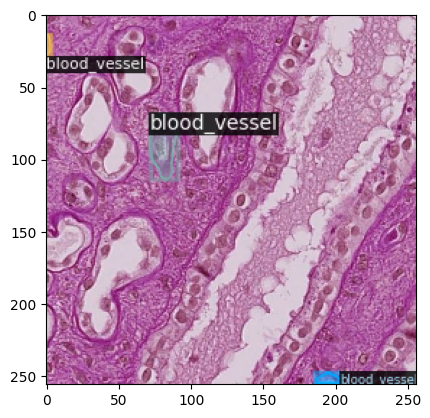

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b_BL_0.15.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[237, 61, 236, 62, 234, 62, 231, 65, 231, 66, 230, 67, 230, 70, 228, 72, 228, 73, 226, 75, 226, 76, 224, 78, 224, 80, 223, 81, 223, 82, 222, 83, 222, 90, 221, 91, 221, 92, 220, 93, 220, 108, 221, 109, 221, 118, 222, 119, 222, 120, 223, 121, 223, 123, 224, 124, 224, 126, 225, 127, 225, 128, 227, 130, 228, 130, 229, 131, 229, 132, 230, 133, 230, 134, 233, 137, 233, 140, 234, 141, 234, 143, 235, 144, 235, 147, 238, 150, 239, 150, 240, 151, 246, 151, 249, 148, 249, 147, 250, 146, 250, 145, 251, 144, 251, 143, 252, 142, 252, 136, 251, 135, 251, 130, 250, 129, 251, 128, 251, 127, 252, 126, 252, 113, 253, 112, 253, 109, 254, 108, 254, 104, 255, 103, 255, 101, 256, 100, 256, 94, 257, 93, 257, 92, 258, 91, 258, 90, 257, 89, 257, 86, 256, 85, 256, 79, 255, 78, 255, 75, 254, 74, 254, 73, 253, 

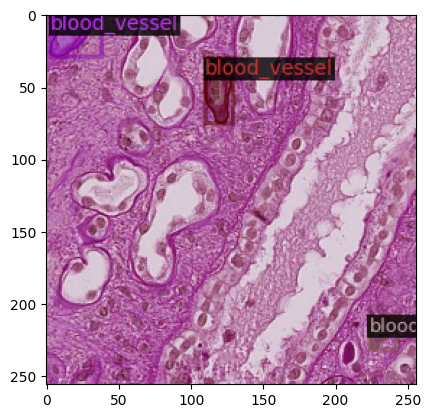

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b_BL_0.3.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[302, 0, 301, 1, 301, 3, 300, 4, 300, 5, 299, 6, 299, 13, 298, 14, 298, 15, 297, 16, 297, 31, 298, 32, 298, 41, 299, 42, 299, 43, 300, 44, 300, 46, 301, 47, 301, 49, 302, 50, 302, 51, 304, 53, 305, 53, 306, 54, 306, 55, 307, 56, 307, 57, 310, 60, 310, 63, 311, 64, 311, 66, 312, 67, 312, 70, 315, 73, 316, 73, 317, 74, 323, 74, 326, 71, 326, 70, 327, 69, 327, 68, 328, 67, 328, 66, 329, 65, 329, 59, 328, 58, 328, 53, 327, 52, 328, 51, 328, 50, 329, 49, 329, 36, 330, 35, 330, 32, 331, 31, 331, 27, 332, 26, 332, 24, 333, 23, 333, 17, 334, 16, 334, 15, 335, 14, 335, 13, 334, 12, 334, 9, 333, 8, 333, 2, 332, 1, 332, 0]], 'area': 2086.0, 'bbox': [297, 0, 335, 74], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'segmentation': [[94, 485, 93, 486, 89, 486, 88, 487, 86, 487, 85, 488, 8

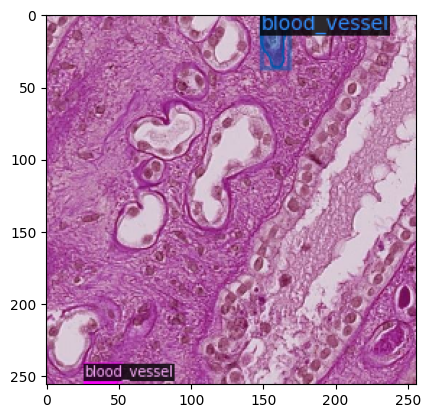

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b_BL_0.45.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[171, 408, 170, 409, 166, 409, 165, 410, 163, 410, 162, 411, 160, 411, 159, 412, 157, 412, 156, 413, 155, 413, 153, 415, 151, 415, 149, 417, 147, 417, 146, 418, 145, 418, 142, 421, 141, 421, 140, 422, 140, 423, 131, 432, 131, 433, 130, 434, 130, 435, 129, 436, 129, 437, 128, 438, 128, 439, 127, 440, 127, 442, 126, 443, 126, 462, 125, 463, 125, 464, 124, 465, 124, 466, 123, 467, 123, 468, 122, 469, 122, 470, 121, 471, 121, 472, 119, 474, 119, 475, 117, 477, 117, 478, 115, 480, 115, 482, 114, 483, 114, 484, 112, 486, 112, 487, 111, 488, 111, 489, 110, 490, 110, 492, 108, 494, 108, 495, 107, 496, 107, 498, 105, 500, 105, 501, 104, 502, 104, 503, 103, 504, 103, 505, 102, 506, 102, 507, 100, 509, 100, 510, 99, 511, 141, 511, 142, 510, 142, 508, 143, 507, 143, 506, 145, 504, 145, 502, 146

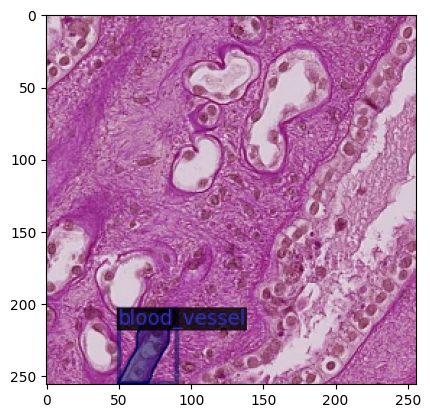

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/0033bbc76b6b_BL_0.6.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[511, 465, 509, 467, 508, 467, 507, 468, 504, 468, 503, 469, 501, 469, 500, 470, 499, 470, 498, 471, 497, 471, 496, 472, 495, 472, 493, 474, 492, 474, 489, 477, 489, 478, 487, 480, 487, 482, 483, 486, 482, 486, 478, 490, 478, 491, 477, 492, 477, 497, 478, 498, 478, 499, 480, 501, 482, 501, 483, 502, 490, 502, 491, 503, 497, 503, 498, 502, 500, 502, 501, 501, 502, 501, 503, 500, 504, 500, 505, 499, 507, 499, 508, 498, 509, 498, 511, 496]], 'area': 861.5, 'bbox': [477, 465, 511, 503], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'segmentation': [[248, 331, 247, 332, 243, 332, 242, 333, 240, 333, 239, 334, 237, 334, 236, 335, 234, 335, 233, 336, 232, 336, 230, 338, 228, 338, 226, 340, 224, 340, 223, 341, 222, 341, 219, 344, 218, 344, 217, 345, 217, 346, 208, 355, 208, 356, 20

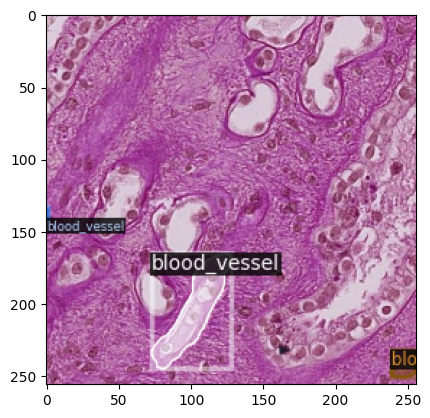

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[471, 375, 470, 375, 469, 375, 468, 375, 467, 375, 466, 375, 466, 374, 465, 374, 464, 374, 463, 374, 463, 373, 462, 373, 461, 373, 461, 372, 460, 372, 459, 372, 458, 372, 457, 372, 457, 371, 456, 371, 455, 371, 454, 371, 454, 370, 453, 370, 452, 370, 451, 370, 451, 369, 450, 369, 449, 369, 449, 368, 448, 368, 448, 367, 447, 367, 446, 367, 445, 367, 445, 366, 444, 366, 443, 366, 443, 365, 443, 364, 442, 364, 442, 363, 442, 362, 441, 362, 441, 361, 440, 361, 440, 360, 440, 359, 439, 359, 439, 358, 438, 358, 438, 357, 438, 356, 437, 356, 437, 355, 436, 355, 436, 354, 436, 353, 435, 353, 435, 352, 434, 352, 434, 351, 434, 350, 433, 350, 433, 349, 432, 349, 432, 348, 432, 347, 431, 347, 431, 346, 430, 346, 430, 345, 429, 345, 429, 344, 428, 344, 428, 343, 427, 343, 427, 342, 426, 342, 426, 341, 

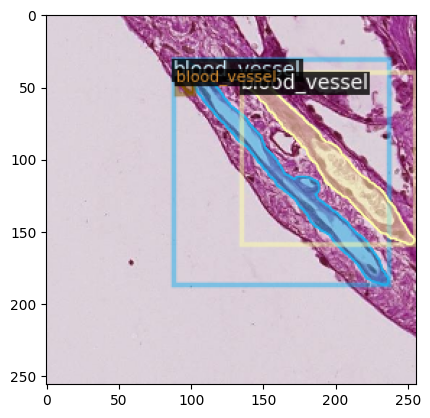

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.15.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[110, 63, 109, 64, 107, 64, 106, 65, 103, 65, 102, 66, 101, 66, 100, 67, 100, 68, 99, 69, 99, 72, 100, 73, 100, 74, 101, 74, 102, 75, 105, 75, 109, 79, 109, 80, 110, 81, 110, 82, 111, 82, 112, 83, 112, 84, 113, 84, 114, 85, 115, 85, 121, 91, 121, 92, 122, 92, 125, 95, 125, 96, 127, 98, 127, 99, 128, 100, 128, 101, 130, 103, 130, 104, 131, 105, 131, 106, 132, 107, 132, 108, 134, 110, 134, 111, 139, 116, 139, 117, 141, 119, 141, 120, 143, 122, 143, 123, 144, 123, 145, 124, 145, 125, 146, 126, 146, 127, 147, 127, 150, 130, 150, 131, 151, 131, 154, 134, 154, 135, 156, 137, 156, 138, 160, 142, 160, 143, 165, 148, 165, 149, 166, 149, 167, 150, 168, 150, 169, 151, 169, 152, 170, 152, 171, 153, 171, 154, 173, 156, 173, 157, 175, 159, 176, 159, 177, 160, 177, 161, 184, 168, 184, 169, 186, 171

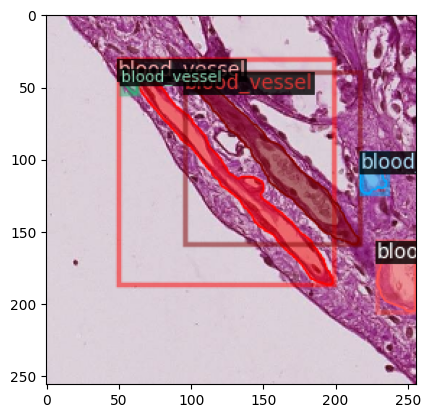

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.3.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[33, 63, 32, 64, 30, 64, 29, 65, 26, 65, 25, 66, 24, 66, 23, 67, 23, 68, 22, 69, 22, 72, 23, 73, 23, 74, 24, 74, 25, 75, 28, 75, 32, 79, 32, 80, 33, 81, 33, 82, 34, 82, 35, 83, 35, 84, 36, 84, 37, 85, 38, 85, 44, 91, 44, 92, 45, 92, 48, 95, 48, 96, 50, 98, 50, 99, 51, 100, 51, 101, 53, 103, 53, 104, 54, 105, 54, 106, 55, 107, 55, 108, 57, 110, 57, 111, 62, 116, 62, 117, 64, 119, 64, 120, 66, 122, 66, 123, 67, 123, 68, 124, 68, 125, 69, 126, 69, 127, 70, 127, 73, 130, 73, 131, 74, 131, 77, 134, 77, 135, 79, 137, 79, 138, 83, 142, 83, 143, 88, 148, 88, 149, 89, 149, 90, 150, 91, 150, 92, 151, 92, 152, 93, 152, 94, 153, 94, 154, 96, 156, 96, 157, 98, 159, 99, 159, 100, 160, 100, 161, 107, 168, 107, 169, 109, 171, 109, 172, 110, 173, 110, 174, 111, 174, 115, 178, 116, 178, 119, 181, 120, 

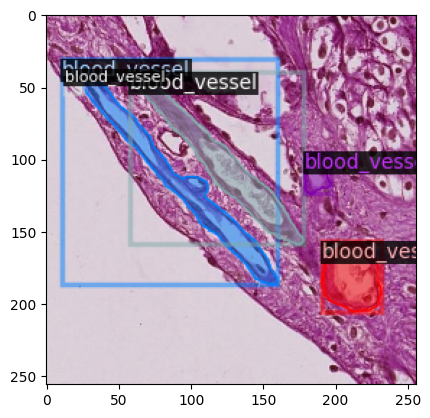

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.45.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[0, 96, 0, 135, 2, 137, 2, 138, 6, 142, 6, 143, 11, 148, 11, 149, 12, 149, 13, 150, 14, 150, 15, 151, 15, 152, 16, 152, 17, 153, 17, 154, 19, 156, 19, 157, 21, 159, 22, 159, 23, 160, 23, 161, 30, 168, 30, 169, 32, 171, 32, 172, 33, 173, 33, 174, 34, 174, 38, 178, 39, 178, 42, 181, 43, 181, 45, 183, 46, 183, 48, 185, 48, 186, 52, 190, 52, 191, 53, 192, 53, 193, 54, 193, 56, 195, 56, 196, 60, 200, 60, 201, 61, 202, 61, 203, 63, 205, 63, 206, 64, 206, 67, 209, 67, 210, 68, 211, 68, 212, 69, 212, 70, 213, 70, 214, 72, 216, 73, 216, 75, 218, 75, 219, 76, 220, 76, 221, 77, 222, 77, 223, 81, 227, 82, 227, 86, 231, 86, 232, 87, 233, 87, 235, 88, 236, 88, 237, 90, 239, 91, 239, 92, 240, 93, 240, 95, 242, 96, 242, 99, 245, 100, 245, 101, 246, 101, 247, 102, 247, 104, 249, 105, 249, 107, 251, 1

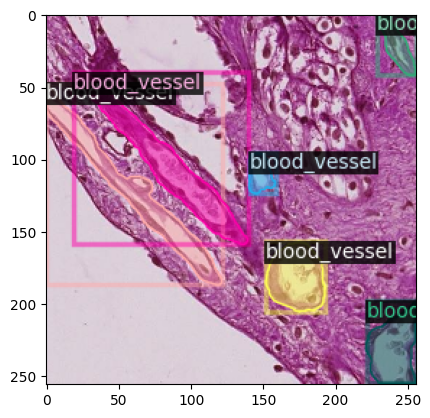

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.6.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[0, 189, 0, 223, 4, 227, 5, 227, 9, 231, 9, 232, 10, 233, 10, 235, 11, 236, 11, 237, 13, 239, 14, 239, 15, 240, 16, 240, 18, 242, 19, 242, 22, 245, 23, 245, 24, 246, 24, 247, 25, 247, 27, 249, 28, 249, 30, 251, 30, 252, 31, 252, 34, 255, 35, 255, 37, 257, 37, 258, 39, 260, 39, 261, 40, 262, 40, 263, 42, 265, 42, 266, 45, 269, 46, 269, 49, 272, 49, 273, 50, 274, 50, 275, 51, 275, 53, 277, 53, 278, 55, 280, 55, 282, 56, 283, 56, 284, 57, 285, 57, 286, 58, 287, 58, 288, 59, 289, 60, 289, 63, 292, 63, 293, 64, 294, 65, 294, 66, 295, 67, 295, 68, 296, 69, 296, 71, 298, 71, 299, 72, 299, 73, 300, 74, 300, 75, 301, 76, 301, 77, 302, 78, 302, 79, 303, 80, 303, 82, 305, 83, 305, 86, 308, 86, 309, 88, 311, 88, 312, 90, 314, 90, 315, 95, 320, 95, 321, 96, 321, 100, 325, 100, 326, 101, 326, 107, 

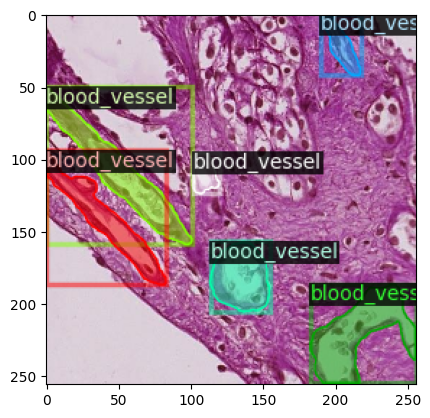

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.75.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[0, 260, 0, 301, 1, 302, 2, 302, 3, 303, 4, 303, 6, 305, 7, 305, 10, 308, 10, 309, 12, 311, 12, 312, 14, 314, 14, 315, 19, 320, 19, 321, 20, 321, 24, 325, 24, 326, 25, 326, 31, 332, 32, 332, 33, 333, 34, 333, 35, 334, 35, 335, 36, 336, 36, 337, 38, 337, 39, 338, 39, 339, 40, 340, 41, 340, 42, 341, 42, 342, 48, 348, 48, 349, 50, 351, 50, 352, 52, 354, 52, 355, 54, 357, 54, 358, 56, 360, 56, 361, 58, 363, 58, 364, 59, 365, 59, 366, 60, 366, 61, 367, 63, 367, 65, 369, 66, 369, 67, 370, 69, 370, 70, 371, 72, 371, 73, 372, 76, 372, 77, 373, 78, 373, 79, 374, 81, 374, 82, 375, 87, 375, 88, 374, 89, 374, 89, 373, 90, 372, 90, 366, 89, 365, 89, 364, 88, 363, 88, 362, 87, 362, 86, 361, 86, 359, 85, 358, 85, 357, 81, 353, 81, 351, 80, 350, 80, 347, 79, 346, 79, 345, 78, 344, 78, 341, 77, 340, 

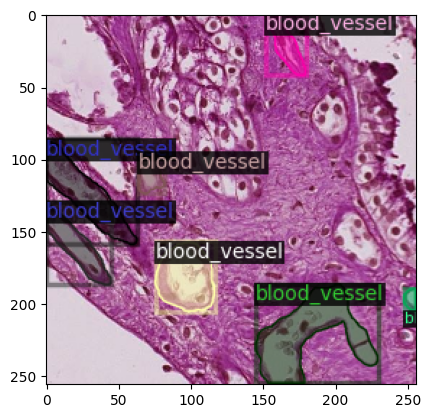

/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files/all_dataset1_imgs_merged/e6d9bd78b840_R_0.9.png
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])
[{'segmentation': [[0, 339, 0, 373, 1, 373, 2, 374, 4, 374, 5, 375, 10, 375, 11, 374, 12, 374, 12, 373, 13, 372, 13, 366, 12, 365, 12, 364, 11, 363, 11, 362, 10, 362, 9, 361, 9, 359, 8, 358, 8, 357, 4, 353, 4, 351, 3, 350, 3, 347, 2, 346, 2, 345, 1, 344, 1, 341, 0, 340]], 'area': 252.0, 'bbox': [0, 339, 13, 375], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'segmentation': [[0, 240, 0, 301, 1, 302, 2, 302, 3, 303, 4, 303, 5, 304, 9, 304, 12, 307, 12, 308, 13, 308, 15, 310, 16, 310, 17, 311, 22, 311, 23, 312, 24, 312, 25, 313, 27, 313, 28, 314, 30, 314, 31, 315, 33, 315, 34, 316, 36, 316, 38, 318, 39, 318, 40, 319, 44, 319, 45, 318, 46, 318, 48, 316, 48, 315, 49, 314, 49, 311, 48, 310, 48, 309, 46, 307, 45, 307, 43, 305, 43, 304, 41, 302, 41, 301, 40, 300, 40, 299, 38, 297, 38, 296, 37, 295, 3

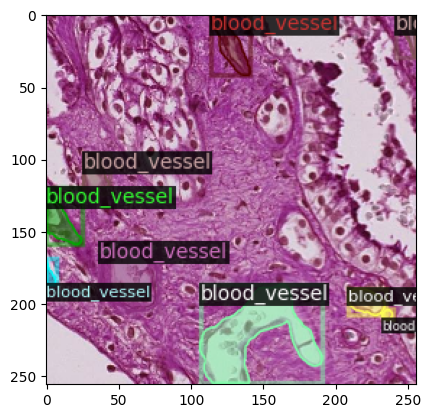

In [8]:
import matplotlib.pyplot as plt
import random
tgt_coco_dicts = [dataset_dicts[i] for i in range(5)]
tgt_dict = None
for d in dataset_dicts:
    if 'e6d9bd78b840' in d['file_name']:
        tgt_coco_dicts.append(d)

for i, d in enumerate(tgt_coco_dicts):
    # read the image with cv2
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    print(d.keys())
    print(d['annotations'])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()